In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

questo con una personal CNN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import os
from torch.utils.data import ConcatDataset

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
import numpy as np
import seaborn as sns

In order to set-up the dataset I had to download if folllowing an online procedure. 
The dataset was dismissed by torchivision and is not more available.

The directory structure should be:

└── stanford_cars 
    └── cars_test_annos_withlabels.mat 
    └── cars_train
        └── *.jpg
    └── cars_test
        └── .*jpg
    └── devkit
        ├── cars_meta.mat
        ├── cars_test_annos.mat
        ├── cars_train_annos.mat
        ├── eval_train.m
        ├── README.txt
        └── train_perfect_preds.txt

In [5]:
# Load the dataset
dataset = torchvision.datasets.StanfordCars(root="./")

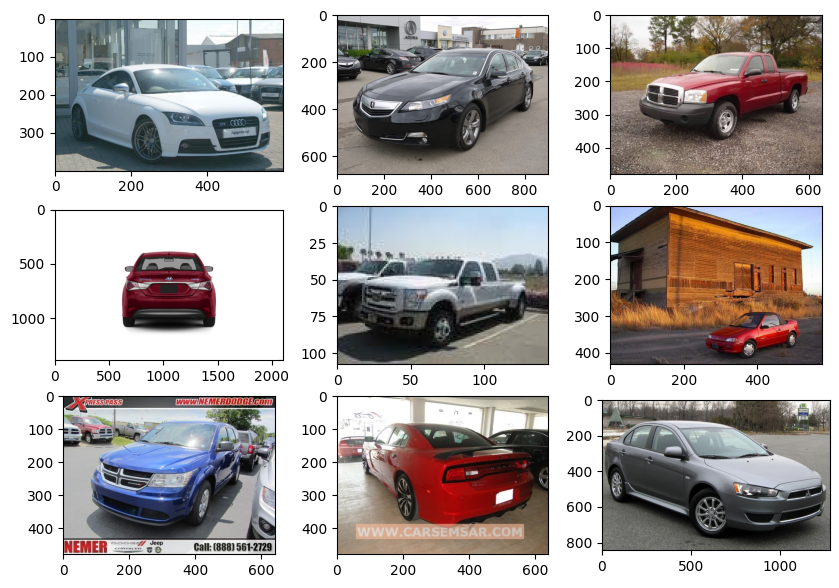

In [6]:
# Display some random images of the dataset
fig, ax = plt.subplots(3, 3, figsize=(10, 7))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(dataset[i * 3 + j][0])
        ax[i, j].axis("on")
plt.show()

changes this part 

In [7]:
# Define transformations for training and validation sets
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.StanfordCars(root="./", split='train', transform=transform_train)
val_dataset = datasets.StanfordCars(root="./", split='test', transform=transform_val)

# Original dataset without augmentations
transform_original = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Original training dataset
train_dataset_original = datasets.StanfordCars(root="./", split='train', transform=transform_original)

# Combined dataset with both original and augmented images
combined_train_dataset = ConcatDataset([train_dataset, train_dataset_original])

# Create data loaders
train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)

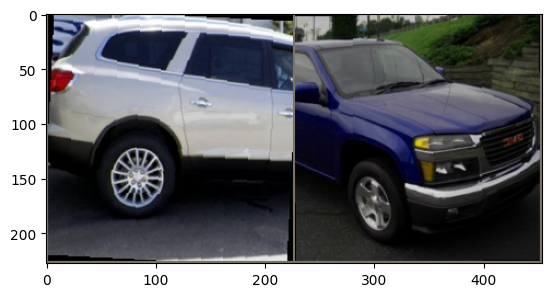

In [8]:
# Display some augmented images from the training set
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def show_augmented_images(dataloader):
    inputs, classes = next(iter(dataloader))
    out = torchvision.utils.make_grid(inputs)
    imshow(out)

# Create a DataLoader for visualization with a small batch size
vis_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Display some augmented images
show_augmented_images(vis_loader)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau


class SimpleCNN(nn.Module):
   def __init__(self, num_classes=196):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)  
    
   def forward(self, x):
    # Convolutional layers with ReLU activation, batch normalization, and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Global Average Pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x

# Instantiate the model and move to device
model = SimpleCNN(num_classes=196)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = model.to(device)

print(f"Using device: {device}")
print(f"Device: {device}")

Using device: mps
Device: mps


In [10]:
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=512, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=196,

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/Users/carpanini24/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
# Function to create a new run directory
def create_new_run_dir(base_log_dir):
    run_number = 0
    while os.path.exists(os.path.join(base_log_dir, f"{run_number:04d}")):
        run_number += 1
    new_run_dir = os.path.join(base_log_dir, f"{run_number:04d}")
    os.makedirs(new_run_dir)
    return new_run_dir

# Base log directory
base_log_dir = "./runs/StanfordCars/"

# Create a new run directory
log_dir = create_new_run_dir(base_log_dir)
writer = SummaryWriter(log_dir)

In [13]:
# Assume model, train_loader, val_loader, criterion, and optimizer are defined
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SimpleCNN(num_classes=196).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# TensorBoard writer
writer = SummaryWriter()

# Number of epochs
num_epochs = 150

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.float() / len(train_loader.dataset)

    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/train', epoch_acc, epoch)
    
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.float() / len(val_loader.dataset)

    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)
    
    # Adjust the learning rate based on the validation loss
    scheduler.step(val_loss)
    
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# Close the TensorBoard writer
writer.close()

Epoch 1/150
Train Loss: 5.2457 Acc: 0.0088
Val Loss: 5.1778 Acc: 0.0137
Epoch 2/150
Train Loss: 5.2064 Acc: 0.0108
Val Loss: 5.1636 Acc: 0.0108
Epoch 3/150
Train Loss: 5.2012 Acc: 0.0111
Val Loss: 5.1517 Acc: 0.0126
Epoch 4/150
Train Loss: 5.1870 Acc: 0.0114
Val Loss: 5.1478 Acc: 0.0117
Epoch 5/150
Train Loss: 5.1781 Acc: 0.0104
Val Loss: 5.1322 Acc: 0.0124
Epoch 6/150
Train Loss: 5.1595 Acc: 0.0120
Val Loss: 5.1308 Acc: 0.0119
Epoch 7/150
Train Loss: 5.1547 Acc: 0.0114
Val Loss: 5.1248 Acc: 0.0137
Epoch 8/150
Train Loss: 5.1427 Acc: 0.0126
Val Loss: 5.1165 Acc: 0.0173
Epoch 9/150
Train Loss: 5.1323 Acc: 0.0141
Val Loss: 5.0841 Acc: 0.0173
Epoch 10/150
Train Loss: 5.1077 Acc: 0.0168
Val Loss: 5.0802 Acc: 0.0230
Epoch 11/150
Train Loss: 5.0773 Acc: 0.0169
Val Loss: 5.0218 Acc: 0.0249
Epoch 12/150
Train Loss: 5.0449 Acc: 0.0211
Val Loss: 4.9805 Acc: 0.0281
Epoch 13/150
Train Loss: 5.0165 Acc: 0.0224
Val Loss: 5.0114 Acc: 0.0256
Epoch 14/150
Train Loss: 4.9750 Acc: 0.0232
Val Loss: 4.8964

In [14]:
torch.save(model.state_dict(), 'trained_model10.pth')

In [15]:
# Ensure the model is in evaluation mode
model.eval()

# Lists to store true labels and predictions
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [16]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

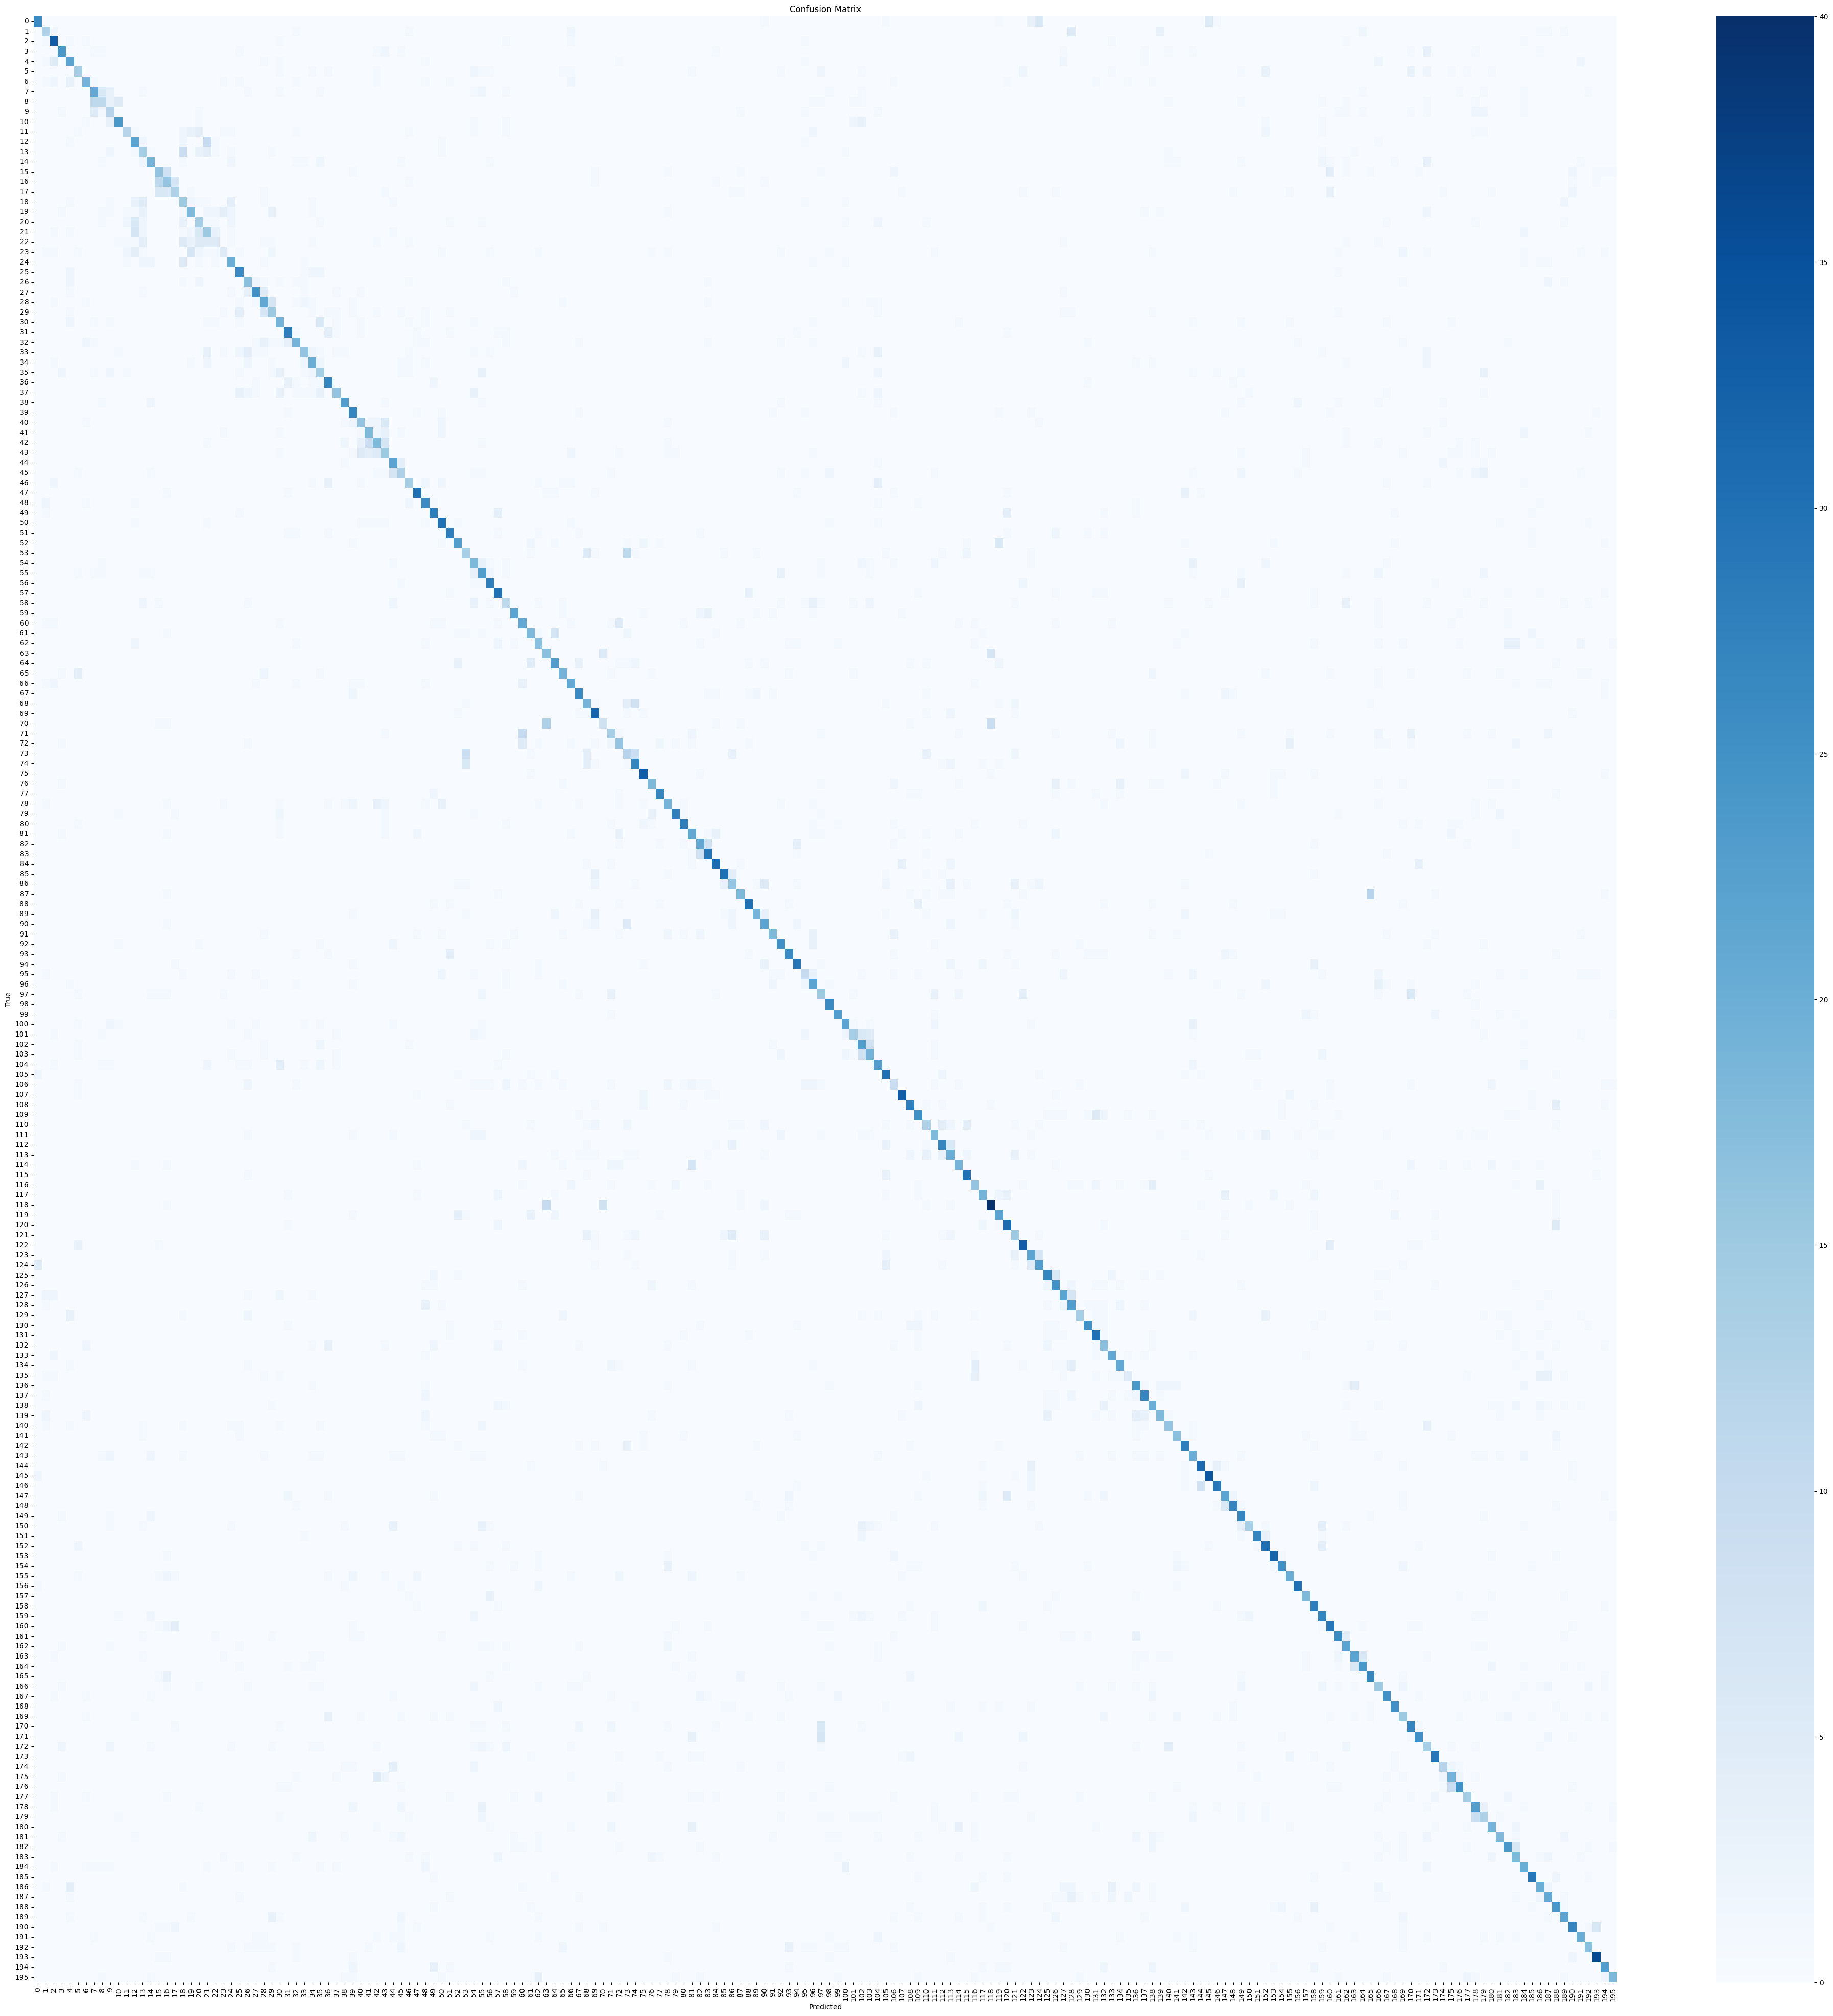

In [17]:
# Plot the confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=range(196), yticklabels=range(196))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

# Function to show an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of validation data
inputs, labels = next(iter(val_loader))
inputs, labels = inputs.to(device), labels.to(device)

# Forward pass to get predictions
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Define a list of class names if available
class_names = [str(i) for i in range(196)]  # Modify this with actual class names if available

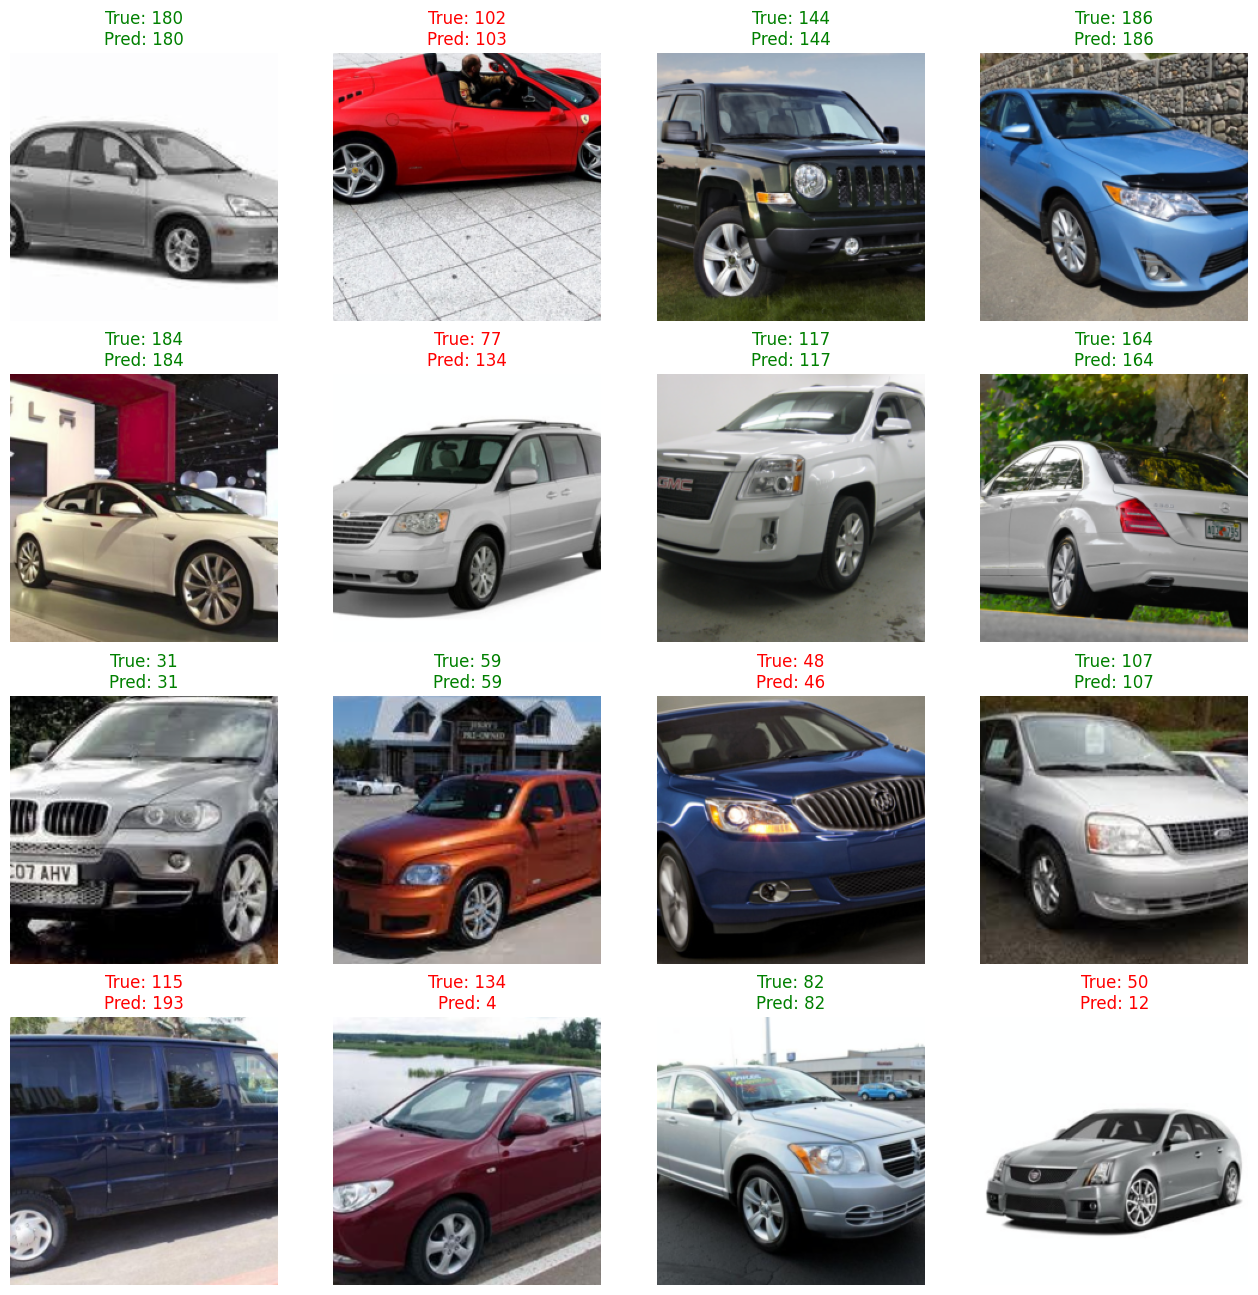

In [19]:
# Display images with predictions and true labels
plt.figure(figsize=(16, 16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    imshow(inputs.cpu().data[i])
    true_label = class_names[labels[i].item()] if class_names else labels[i].item()
    pred_label = class_names[preds[i].item()] if class_names else preds[i].item()
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=("green" if true_label == pred_label else "red"))
    ax.axis('off')

plt.show()